In [42]:
from numpy import array
import json
from fastai.text import *
import numpy as np
from sklearn.feature_selection import chi2

In [43]:
def parse_data(file):

    for l in open(file,'r'):
        yield json.loads(l)
    
data =\
list(parse_data('C:/Users/abhi0/OneDrive/Documents/Data_on_Sattire_and_Sarcasm/Sarcasm_Headlines_Dataset.json'))    

#Not used to avoid severe class-imbalance. Model would never generalise to
#any sort of data in the world, if used, without increasing the sarcasm
#data-set. Not using this gives a good ratio of the two classes. 
data2=\
list(parse_data('C:/Users/abhi0/OneDrive/Documents/Data_on_Sattire_and_Sarcasm/Sarcasm_Headlines_Dataset_v2.json'))    


In [44]:
#Extracting the labels,indices and the headlines corresponding to sarcastic
#statements for the first set
sarIdx=[]
Headline=[]
Labels=[]

for i in range(len(data)):
    if data[i]['is_sarcastic']==1:
        sarIdx.append(i)
        Headline.append(data[i]['headline'])
        Labels.append('Sarcasm')       
        
        
###'sattire' data-set: 
import pandas as pd
data3=pd.read_csv('C:/Users/abhi0/OneDrive/Documents/Data_on_Sattire_and_Sarcasm/OnionOrNot.csv')        

In [73]:
satIdx=[]

#Sarcasm ending Index:
sarEndIdx=len(Headline)        

for j in range(len(data3)):
    if data3['label'][j]==1:
        satIdx.append(j)
        Labels.append('Satire') 
        Headline.append(data3['text'][j])
        
        
#merging columsn into a dataframe:
df = pd.DataFrame(
    {'Labels': Labels,
     'Headlines': Headline,
    })        

In [74]:
df.head()

,Labels,Headlines
0,Sarcasm,mom starting to fear son's web series closest ...
1,Sarcasm,"boehner just wants wife to listen, not come up..."
2,Sarcasm,top snake handler leaves sinking huckabee camp...
3,Sarcasm,nuclear bomb detonates during rehearsal for 's...
4,Sarcasm,cosby lawyer asks why accusers didn't come for...


In [75]:
#Creating training and validation splits:
from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(df, stratify = df['Labels'], test_size = 0.3,shuffle=True)
df_trn.shape, df_val.shape

((20806, 2), (8918, 2))

In [76]:
df_trn.head()

,Labels,Headlines
1397,Sarcasm,report: american dream now an out-of-court set...
17049,Satire,Life: 5 Honor Students Who Aren’t Such Hot Shi...
723,Sarcasm,passion with which child demanding balloon act...
10246,Sarcasm,new rap song samples 'billie jean' in its enti...
22112,Satire,Guards Gun Down Four Angels Escaping From Heaven


In [77]:
df_val.head()

,Labels,Headlines
24943,Satire,Trump Deploys National Guard To Press Conferen...
2693,Sarcasm,systems administrator would so fuck new trainee
16126,Satire,New Study Finds Humans Could Lose Vestigial He...
18458,Satire,Video: It Takes A Village: Watch 15 Men Teach ...
11291,Sarcasm,trump accidentally fires off 'boring mike penc...


In [78]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [81]:
data_clas.show_batch()

text,target
"xxbos xxmaj life : xxmaj if xxmaj you xxmaj love xxmaj enamel xxmaj pins , xxmaj you ’ll xxmaj love xxmaj this xxmaj etsy xxmaj shop , xxmaj and xxmaj if xxmaj you xxmaj do n’t xxmaj care xxmaj about xxmaj enamel xxmaj pins , xxmaj you ’ll xxmaj explode xxmaj over xxmaj this xxmaj picture xxmaj of a xxmaj bulldog xxmaj puppy , xxmaj and xxmaj if xxmaj that",Satire
"xxbos xxmaj news : xxmaj good xxmaj to xxmaj know : xxmaj taylor xxmaj swift xxmaj just xxmaj made xxmaj it xxmaj painstakingly xxmaj clear xxmaj that xxmaj she xxmaj would xxmaj never xxmaj date xxmaj dave xxmaj franco , xxmaj nor xxmaj would xxmaj she xxmaj ever xxmaj have xxmaj any xxmaj interest xxmaj in xxmaj meeting xxmaj him , xxmaj nor xxmaj would xxmaj she xxmaj feel xxmaj",Satire
"xxbos xxmaj its xxmaj biggest xxmaj challenge xxmaj yet : xxmaj netflix xxmaj just xxmaj announced xxmaj that xxmaj every xxmaj episode xxmaj of xxmaj the xxmaj new ‘ xxmaj queer xxmaj eye ’ xxmaj season xxmaj will xxmaj be xxmaj dedicated xxmaj to xxmaj making xxmaj over xxmaj one xxmaj really , xxmaj really xxmaj gross xxmaj hermit xxmaj they xxmaj found xxmaj fucking a xxmaj dead xxmaj turtle",Satire
xxbos a xxmaj beautiful xxmaj reunion : xxmaj this xxmaj high xxmaj school xxmaj football xxmaj player xxmaj got xxmaj the xxmaj surprise xxmaj of a xxmaj lifetime xxmaj when xxmaj he xxmaj removed xxmaj his xxmaj helmet xxmaj to xxmaj reveal xxmaj that xxmaj he xxmaj was xxmaj his xxmaj father xxmaj who xxmaj had xxmaj been xxmaj fighting xxmaj in xxmaj afghanistan xxmaj for xxmaj the xxmaj past,Satire
xxbos xxmaj anyone ’s xxmaj game : xxmaj these xxmaj middle xxmaj school xxmaj talent xxmaj show xxmaj judges xxmaj ca n’t xxmaj decide xxmaj which xxmaj of xxmaj the xxmaj fat - xxmaj kid - xxmaj and - xxmaj janitor xxmaj duos xxmaj who xxmaj tap - xxmaj danced ‘ xxmaj you ’ve xxmaj got a xxmaj friend xxmaj in xxmaj me ’ xxmaj should xxmaj win xxmaj first,Satire


In [82]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 3.02E-02


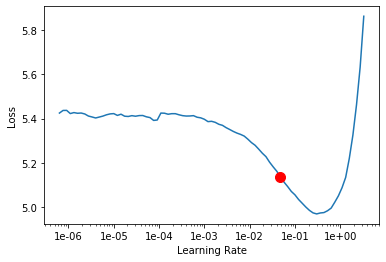

In [83]:
#Using the learning rate finder to find the best learning rate:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [84]:
learn.fit_one_cycle(4, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.035484,3.569563,0.460744,10:46
1,3.474381,3.361071,0.478988,10:51
2,2.845041,3.082000,0.510060,12:44


KeyboardInterrupt: 

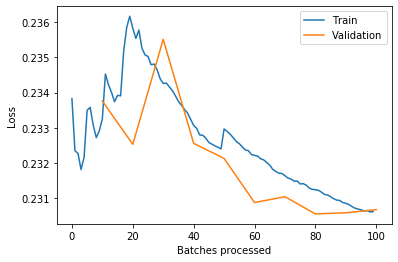

In [53]:
#Plot of training and validation loss
learn.recorder.plot_losses()

In [54]:
#Gradual unfreezing - training first couple of layers:
learn.freeze_to(-2)
learn.fit_one_cycle(10, slice(5e-3, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.229601,0.230770,0.854554,00:45
1,0.229680,0.230625,0.854554,00:45
2,0.229885,0.230483,0.854375,00:44
3,0.229883,0.230113,0.854554,00:44
4,0.229817,0.230168,0.854554,00:39
5,0.229716,0.230203,0.854688,00:40
6,0.229714,0.229956,0.854866,00:46
7,0.229644,0.230045,0.854777,00:48
8,0.229602,0.229923,0.854688,00:48
9,0.229524,0.229972,0.854643,00:48


In [55]:
#Un-freezing all the layers and training the model at a lower learning rate. 
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.229380,0.229947,0.854732,01:22
1,0.229378,0.229838,0.854911,01:21
2,0.229344,0.229748,0.854955,01:21
3,0.229316,0.229767,0.854911,01:20


In [64]:
preds,y,losses = learn.get_preds(with_loss=True)

In [67]:
interp = ClassificationInterpretation(learn, preds, y, losses)

In [72]:
learn.predict("I love those")

'I love those sarcasm'